In this report, we are developing a Physics-Informed Neural Network (PINN) to solve the 2D wave equation using PyTorch.

## Mathematical Formulation

### The 2D Wave Equation

The standard 2D wave equation can be written as:

$$
\frac{\partial^2 u}{\partial t^2} \;=\; c^2 \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right),
$$

where
- $u = u(x, y, t)$ is the wave field (the unknown function we want to solve for),

- $c$ is the wave speed (a known constant).

### Initial and Boundary Conditions

One needs to impose:

1. **Initial displacement**: $u(x, y, 0) = f(x, y)$.

2. **Initial velocity**: $\left.\frac{\partial u}{\partial t}\right|_{t=0} = 0$.

3. **Boundary condition**: Depending on the domain, e.g. for a rectangular domain $\Omega = \{ (x,y) : x \in [a,b], y \in [c,d] \}$, we might impose a Dirichlet boundary, meaning that $u(x,y,t) = 0$ for $(x,y)$ on the boundary $\partial \Omega$.


## PINN Approach

### PINN Concept

A Physics-Informed Neural Network (PINN) encodes the PDE and boundary/initial conditions into the loss function. The neural network approximates the solution $u_\theta(x,y,t)$, where $\theta$ denotes the neural network parameters (weights and biases).

1. **Neural Network**:
   $$
   \hat{u}(x,y,t;\theta) \approx u(x,y,t).
   $$

2. **Loss Function**:

   - **Physics Loss (PDE Residual)**:
     $$
     R_{\text{PDE}} = \left\| \frac{\partial^2 \hat{u}}{\partial t^2} - c^2 \left(\frac{\partial^2 \hat{u}}{\partial x^2} + \frac{\partial^2 \hat{u}}{\partial y^2}\right) \right\|^2,
     $$
     measured at random “collocation points” inside the space-time domain.

   - **Initial/Boundary Condition Loss**:

  $$
     R_{\text{BC/IC}} = \left\|\hat{u}(x, y, 0;\theta) - f(x,y)\right\|^2 + \left\|\left.\frac{\partial \hat{u}}{\partial t}\right|_{t=0}-0\right\|^2 + \left\|\left. \hat{u}\right|_{\partial \Omega}-0\right\|^2
  $$

3. **Combined Loss**:

   $$
   \mathcal{L}(\theta) = R_{\text{PDE}} + R_{\text{BC/IC}}.
   $$

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


### Define the Neural Network Architecture:
We implement a feed-forward fully connected network:
- Input layer: 3 inputs $(x, y, t)$.

- Several hidden layers with e.g. 20-50 neurons each and a smooth activation function (e.g. `tanh`).

- Output layer: 1 output $u$.

In [3]:
class WaveNet(nn.Module):
    def __init__(self, layers=[3, 50, 50, 50, 50, 1]):
        """
        layers: list containing number of neurons in each layer
        e.g., [3, 50, 50, 1] means input=3, two hidden layers with 50 each, output=1
        """
        super(WaveNet, self).__init__()
        self.activation = nn.Tanh()

        # Create a list of fully-connected layers
        layer_list = []
        for i in range(len(layers)-1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

        # Initialize weights
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        x shape: (batch_size, 3)  # i.e. [x, y, t]
        """
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

### Define the PDE
Let us write a function that takes a neural network $\hat{u}(x, y, t;\theta)$ and computes the PDE residual
  $$r(x,y,t) = \frac{\partial^2 \hat{u}}{\partial t^2} - c^2 \left(\frac{\partial^2 \hat{u}}{\partial x^2} + \frac{\partial^2 \hat{u}}{\partial y^2}\right).$$

To handle the PDE residual, we need $\frac{\partial \hat{u}}{\partial t}$, $\frac{\partial^2 \hat{u}}{\partial t^2}$ and $\frac{\partial^2 \hat{u}}{\partial x^2}$, $\frac{\partial^2 \hat{u}}{\partial y^2}$.

With PyTorch, we can use `torch.autograd.grad` to compute these derivatives automatically, as long as we keep `requires_grad=True` for $(x, y, t)$.

In [4]:
def wave_pde_residual(x, y, t, model, c):
    """
    Returns the PDE residual:
    r = u_tt - c^2 (u_xx + u_yy)
    x, y, t are tensors with shape (N,1)
    """
    # Enable gradient tracking
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    # Forward pass
    u = model(torch.cat([x, y, t], dim=1))  # shape (N, 1)

    # First-order derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second-order derivatives
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # PDE residual
    residual = u_tt - c**2 * (u_xx + u_yy)
    return residual

### Data Sampling (Collocation Points)

1. **Interior Points**: Sample $(x_i, y_i, t_i)$ from the space-time domain for enforcing the PDE residual.

2. **Initial Points**: Sample $(x_i, y_i, t_i=0)$ to enforce initial conditions.

3. **Boundary Points**: Sample $(x_i, y_i)$ on the boundary for each time $t$ in the relevant interval to enforce boundary conditions.

In [5]:
# Example domain: x in [0,1], y in [0,1], t in [0,1]
N_collocation = 5000  # Number of interior collocation points
N_boundary = 200      # Number of boundary points
N_initial = 200       # Number of points at t=0

# Collocation points inside the domain
x_collocation = torch.rand(N_collocation, 1).to('cuda')
y_collocation = torch.rand(N_collocation, 1).to('cuda')
t_collocation = torch.rand(N_collocation, 1).to('cuda')

# Boundary points (assuming Dirichlet boundary at x=0 or x=1, y=0 or y=1)
# Here just sampling for demonstration - adapt to your problem
x_bc = torch.cat([
    torch.zeros(N_boundary//4,1),
    torch.ones(N_boundary//4,1),
    torch.rand(N_boundary//4,1),
    torch.rand(N_boundary//4,1)
], dim=0).to('cuda')
y_bc = torch.cat([
    torch.rand(N_boundary//4,1),
    torch.rand(N_boundary//4,1),
    torch.zeros(N_boundary//4,1),
    torch.ones(N_boundary//4,1)
], dim=0).to('cuda')
t_bc = torch.rand(N_boundary,1).to('cuda')

# For boundary conditions, define a boundary function, e.g. u=0
u_bc = torch.zeros(N_boundary,1).to('cuda')

# Initial points (t=0)
x_ic = torch.rand(N_initial,1).to('cuda')
y_ic = torch.rand(N_initial,1).to('cuda')
t_ic = torch.zeros(N_initial,1).to('cuda')

# Suppose initial displacement is f(x,y)=sin(pi*x)*sin(pi*y)
u_ic = torch.sin(np.pi * x_ic) * torch.sin(np.pi * y_ic)  # shape [N_initial,1]
u_ic = u_ic.to('cuda')

# Suppose initial velocity is 0
# We'll use this in the PDE residual or a separate loss term as needed.

Now, we will define the loss function we discussed above, which will be the quantity to be minimized.

In [6]:
model = WaveNet(layers=[3, 50, 50, 50, 50, 1]).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c = 1.0  # wave speed, for example

def loss_func():
    # PDE residual loss
    r = wave_pde_residual(x_collocation, y_collocation, t_collocation, model, c)
    loss_pde = torch.mean(r**2)

    # Boundary condition loss (Dirichlet)
    u_pred_bc = model(torch.cat([x_bc, y_bc, t_bc], dim=1))
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    # Initial condition loss (displacement)
    u_pred_ic = model(torch.cat([x_ic, y_ic, t_ic], dim=1))
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # If we also want to enforce initial velocity = 0,
    # we can do that in a similar way by computing u_t at t=0
    x_ic.requires_grad=True
    y_ic.requires_grad=True
    t_ic.requires_grad=True
    u_pred_ic_for_velocity = model(torch.cat([x_ic, y_ic, t_ic], dim=1))
    u_t_ic = torch.autograd.grad(u_pred_ic_for_velocity, t_ic,
                                 grad_outputs=torch.ones_like(u_pred_ic_for_velocity),
                                 create_graph=True)[0]
    loss_ic_velocity = torch.mean(u_t_ic**2)  # since initial velocity is 0

    # Combine losses
    loss = loss_pde + loss_bc + loss_ic + loss_ic_velocity
    loss = loss.to('cuda')
    return loss

In [11]:
# Training
losses = []
num_epochs = 20000
start = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        losses.append(loss.item())
        print(f'Epoch {epoch}, Loss {loss.item():.6e}')
end = time.time()
print(f"Training completed in {end - start:.2f} seconds")

Epoch 0, Loss 4.835552e-04
Epoch 1000, Loss 8.411444e-04
Epoch 2000, Loss 1.056532e-03
Epoch 3000, Loss 2.179275e-03
Epoch 4000, Loss 3.682256e-04
Epoch 5000, Loss 1.752072e-02
Epoch 6000, Loss 1.292195e-03
Epoch 7000, Loss 5.383361e-04
Epoch 8000, Loss 6.108694e-04
Epoch 9000, Loss 4.261077e-04
Epoch 10000, Loss 1.182493e-02
Epoch 11000, Loss 2.437549e-04
Epoch 12000, Loss 7.411669e-04
Epoch 13000, Loss 6.138322e-04
Epoch 14000, Loss 3.221501e-04
Epoch 15000, Loss 2.095964e-04
Epoch 16000, Loss 1.971403e-04
Epoch 17000, Loss 2.365488e-04
Epoch 18000, Loss 1.769921e-04
Epoch 19000, Loss 1.804743e-04
Training completed in 306.21 seconds


### Comparing with exact solution

Let us recall that our PDE is:

$$
u_{tt} = c^2\,(u_{xx} + u_{yy}), \quad (x, y) \in [0,1]\times[0,1], \quad t\ge 0,
$$

with the following initial conditions:
$$
u(x,y,0) = \sin(\pi x)\,\sin(\pi y),
\quad
u_t(x,y,0) = 0.
$$

A well-known solution for this setup is:

$$
u_{\text{exact}}(x,y,t) \;=\; \sin(\pi x)\,\sin(\pi y)\,\cos\!\bigl(\sqrt{2}\,\pi\,c\, t\bigr).
$$

In [14]:
def exact_solution(x, y, t, c=1.0):
    """
    Compute the exact solution u(x, y, t) for the 2D wave equation.

    Parameters:
        x, y, t: PyTorch tensors
        c: wave speed (default is 1.0)

    Returns:
        PyTorch tensor of shape matching x, y, t
    """
    return (torch.sin(torch.pi * x) *
            torch.sin(torch.pi * y) *
            torch.cos(torch.pi * torch.sqrt(torch.tensor(2.0)) * c * t))

### Sampling Points
- Define the domain in space and time:
     $$
     x \in [x_{\min}, x_{\max}], \quad y \in [y_{\min}, y_{\max}], \quad t \in [0, T].
     $$

- Randomly sample interior collocation points $(x_i, y_i, t_i)$.

- Randomly sample boundary points and initial points.

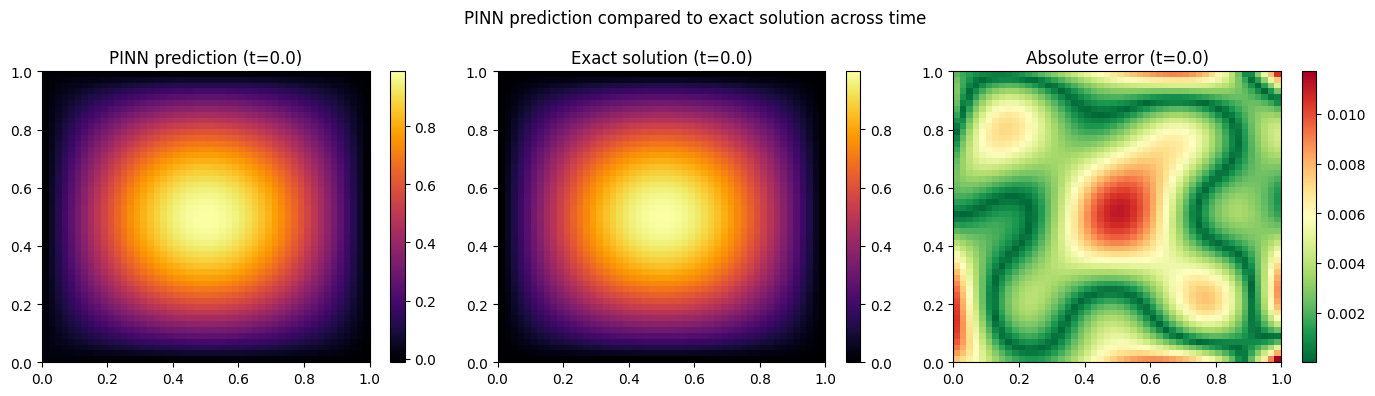

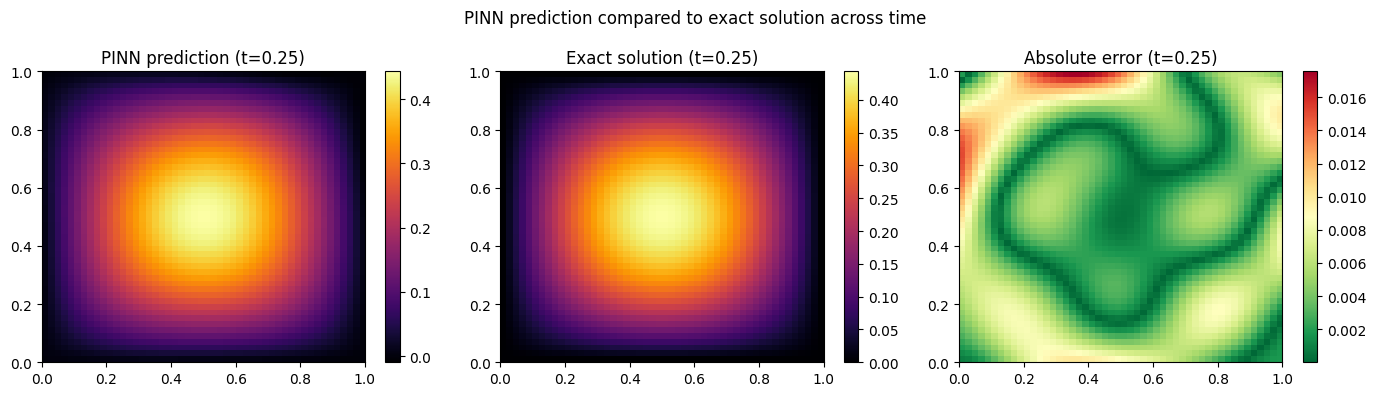

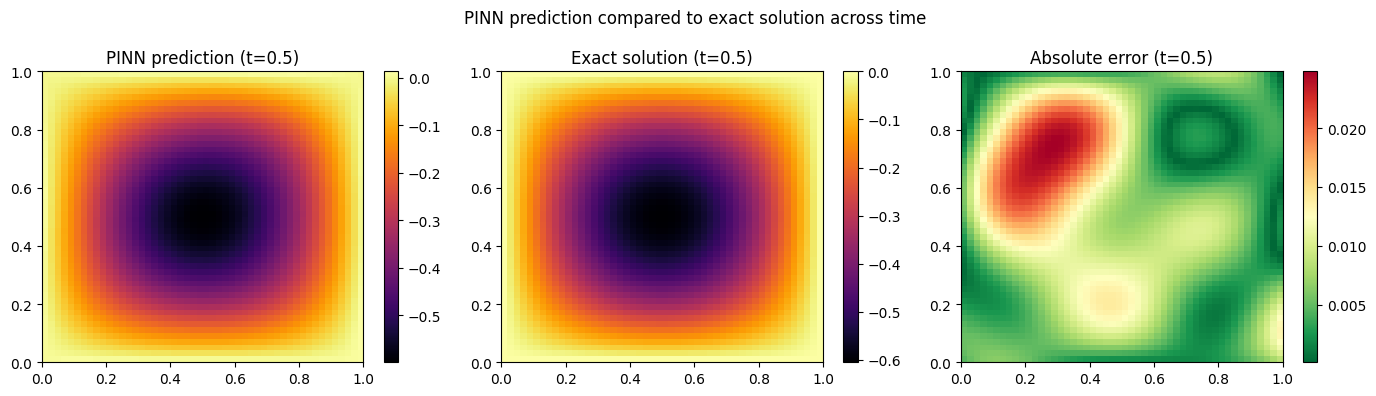

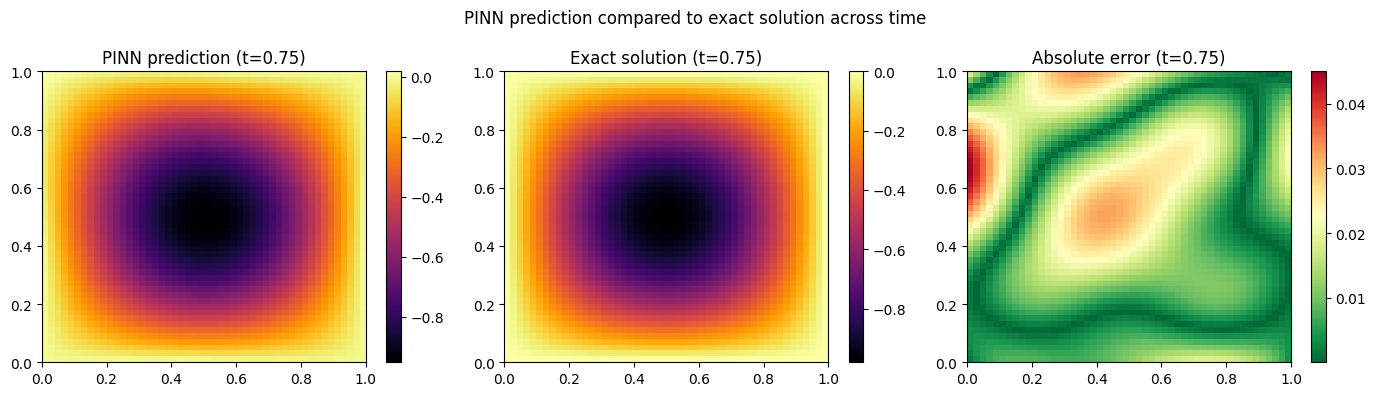

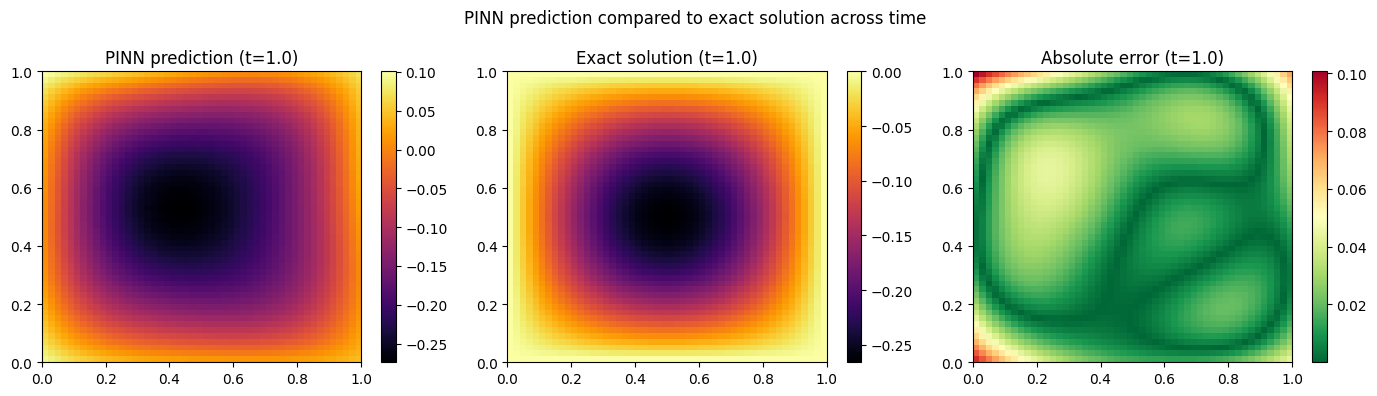

In [15]:
# Suppose our domain is x in [0,1], y in [0,1], t in [0,1]
Nx, Ny = 50, 50  # number of points in each spatial dimension
x_vals = torch.linspace(0, 1, Nx)
y_vals = torch.linspace(0, 1, Ny)

# Create a meshgrid of x, y
X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')  # shape: [Nx, Ny]

# Time snapshots to evaluate
time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]  # Example times

# Loop through each time snapshot
for t_plot in time_snapshots:
    # Flatten X and Y to get a list of points. PyTorch requires shape [N,1]
    X_flat = X.reshape(-1, 1)
    Y_flat = Y.reshape(-1, 1)
    T_flat = torch.full_like(X_flat, t_plot)  # time is constant for all points

    # Pass through the model
    with torch.no_grad():
        u_pred_flat = model(torch.cat([X_flat.to('cuda'), Y_flat.to('cuda'), T_flat.to('cuda')], dim=1))  # shape [Nx*Ny, 1]

    # Reshape the predictions back to [Nx, Ny]
    u_pred = u_pred_flat.reshape(Nx, Ny)

    # Exact solution
    u_exact = exact_solution(X.to('cuda'), Y.to('cuda'), torch.tensor(t_plot).to('cuda'), c=1.0)  # shape [Nx, Ny]

    # Absolute error
    diff = (u_pred - u_exact).abs()

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("PINN prediction compared to exact solution across time")

    # PINN solution
    c0 = axes[0].imshow(u_pred.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='inferno')
    axes[0].set_title(f'PINN prediction (t={t_plot})')
    plt.colorbar(c0, ax=axes[0])

    # Exact solution
    c1 = axes[1].imshow(u_exact.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='inferno')
    axes[1].set_title(f'Exact solution (t={t_plot})')
    plt.colorbar(c1, ax=axes[1])

    # Absolute difference
    c2 = axes[2].imshow(diff.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='RdYlGn_r')
    axes[2].set_title(f'Absolute error (t={t_plot})')
    plt.colorbar(c2, ax=axes[2])

    plt.tight_layout()
    plt.show()


Plots above show results of solving the wave equation using a Physics-Informed Neural Network (PINN) for different time snapshots.

- The PINN demonstrates strong performance in solving the wave equation, particularly at early times.

- While the accuracy diminishes slightly as time progresses, the overall solutions remain qualitatively and quantitatively close to the exact solution.

- Improvements could include adjusting the sampling strategy, increasing network capacity, or introducing time-dependent weighting in the loss function to better handle evolving dynamics.

### Why PINNs Work
 Instead of discretizing the wave equation in a classical sense (finite difference/element), we encode the PDE in the loss by enforcing that the neural network’s outputs satisfy the PDE at sampled interior points. This is effectively a continuous regularization that tries to make the neural network a solution to the wave equation everywhere in the domain.

## Conclusion

We developed a Physics-Informed Neural Network (PINN) framework to solve the 2D wave equation. The wave equation is a second-order partial differential equation (PDE) typically written as:

$$
\frac{\partial^2 u}{\partial t^2} \;=\; c^2 \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right),
$$

where $u(x, y, t)$ is the unknown function (displacement) and $c$ is the wave speed. We imposed initial conditions (displacement and velocity at $t=0$) and Dirichlet boundary conditions on a rectangular domain.

The PINN approach encodes both the PDE and the boundary/initial conditions directly into the loss function of a neural network.

We then trained the neural network on a set of collocation points in space-time. Using automatic differentiation (via PyTorch), the necessary partial derivatives with respect to $x$, $y$, and $t$ were computed directly without explicit finite difference/element stencils.

After training, we evaluated the model on a grid of $(x, y, t)$ points to visualize the predicted solution and compared it to the exact (analytical or reference) solution, generating 2D contour plots and/or 3D surface plots across various time snapshots.

### Advantages of PINN

1. **Mesh-Free Approach**:  
   Traditional numerical methods (e.g., finite elements or finite differences) require meshing or discretizing the domain in space. PINNs, on the other hand, only require collocation points, effectively bypassing the need for a predefined mesh. This can be beneficial in complex domains or higher dimensions.

2. **Automatic Differentiation**:  
   The PDE’s derivatives (up to second order in space and time for the wave equation) are computed via automatic differentiation. This simplifies the implementation significantly, as we do not need to manually implement stencils or symbolic differentiation.

3. **Continuous Approximation**:  
   A PINN directly learns a continuous function $\hat{u}(x, y, t)$. Once trained, the solution can be queried at any point in the domain/time without further interpolation.

4. **Integration with Data**:  
   PINNs easily incorporate extra datasets, such as experimental measurements or partial observations. This is especially advantageous in inverse problems or when the PDE parameters are not fully known and must be learned from data.

### Disadvantages of PINN

1. **Computational Cost & Training Challenges**:  
   Training neural networks—especially for larger domains or more complex PDEs—can be computationally expensive.

2. **Potential Convergence Issues**:  
   Neural networks, in general, can suffer from vanishing/exploding gradients, local minima, or poor convergence if the PDE residual and boundary losses are not well-balanced or if the sampling strategy is inadequate.

3. **Accuracy & Error Bounds**:  
   While classical methods (like finite elements) come with well-studied error estimates and convergence theory, PINNs do not yet have such a comprehensive theoretical framework.

4. **Specialized Acceleration Often Required**:  
   PINNs benefit greatly from **GPU acceleration**; however, this adds more dependencies and hardware requirements. Even with a GPU, runtime can exceed that of a well-optimized finite element solver.

Overall, **PINNs** provide a powerful, flexible, and mesh-free approach to solving PDEs. Their advantages lie in ease of incorporating complex physics, boundary conditions, or data assimilation. However, they can be challenging to train, and their computational cost is often higher than traditional numerical methods.

In [30]:
!jupyter nbconvert --to pdf \
--RegexRemovePreprocessor.patterns="['^!jupyter nbconvert.*']" \
"/content/drive/MyDrive/Colab Notebooks/Learning the Waves: Solving the 2D Wave Equation with Physics-Informed Neural Networks.ipynb"

/usr/local/lib/python3.11/dist-packages/traitlets/traitlets.py:2915: FutureWarning: --RegexRemovePreprocessor.patterns=['^!jupyter nbconvert.*'] for containers is deprecated in traitlets 5.0. You can pass `--RegexRemovePreprocessor.patterns item` ... multiple times to add items to a list.
  warn(
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Learning the Waves: Solving the 2D Wave Equation with Physics-Informed Neural Networks.ipynb to pdf
[NbConvertApp] Support files will be in Learning the Waves: Solving the 2D Wave Equation with Physics-Informed Neural Networks_files/
[NbConvertApp] Making directory ./Learning the Waves: Solving the 2D Wave Equation with Physics-Informed Neural Networks_files
[NbConvertApp] Writing 61275 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, mos